In [224]:
from ddpg_torch import Agent, MPC_Agent
import gym
import numpy as np
import os
from collections import deque
from copy import deepcopy
# My own env!
from environments import OpenField_v00, OpenField_v01, OpenField_v10, ClosedField_v20, ClosedField_v21, ClosedField_v22, ClosedField_v23_dyna, MPC_environment_v40
import matplotlib.pyplot as plt
import numpy as np


**What tests do we want to run?**

- 

In [199]:
# TRAINING

# v22 FW # 1209 Collisions
#ch = np.loadtxt('plotdata/v22_fw_ch.txt', dtype=int)
#sh = np.loadtxt('plotdata/v22_fw_sh.txt', dtype=float)

# V22 Naples # 
#ch = np.loadtxt('plotdata/v22_naples_ch.txt', dtype=int)
#sh = np.loadtxt('plotdata/v22_naples_sh.txt', dtype=float)

## V40 FW
#ch = np.loadtxt('plotdata/v40_fw_ch.txt', dtype=int)
#sh = np.loadtxt('plotdata/v40_fw_ch.txt', dtype=float)
#
## V40 Naples
#ch = np.loadtxt('plotdata/v40_naples_ch.txt', dtype=int)
#sh = np.loadtxt('plotdata/v40_naples_ch.txt', dtype=float)


# RUNNING
#ch = np.loadtxt('rundata/v22_fw_data_ch.txt', dtype=int)
#sh = np.loadtxt('rundata/v22_fw_data_sh.txt', dtype=float)

#ch = np.loadtxt('rundata/v40_v22_fw_data_ch.txt', dtype=int)
#sh = np.loadtxt('rundata/v40_v22_fw_data_sh.txt', dtype=float)


#ch = np.loadtxt('rundata/v22_naples_data_ch.txt', dtype=int)
#sh = np.loadtxt('rundata/v22_naples_data_sh.txt', dtype=float)

#ch = np.loadtxt('rundata/v40_v22_naples_data_ch.txt', dtype=int)
#sh = np.loadtxt('rundata/v40_v22_naples_data_sh.txt', dtype=float)


# Onlt to get training data
ch = np.loadtxt('rundata/v40_v22_fw_dist_1_ch.txt', dtype=int)
sh = np.loadtxt('rundata/v40_v22_fw_dist_1_sh.txt', dtype=float)

### Scores

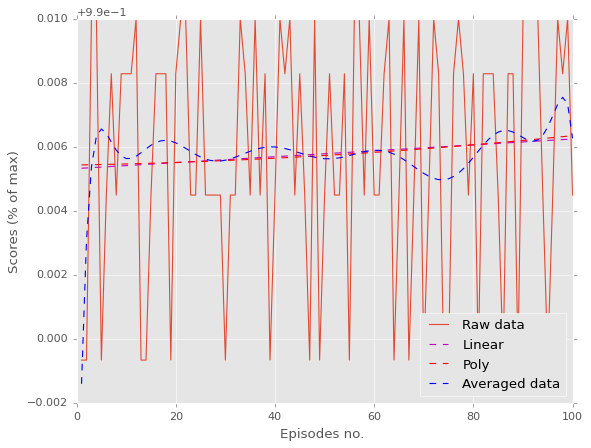

In [201]:
# Normalize the scores
ep_no = len(sh)
ch = ch[0:ep_no]

sh = sh / sh.max()


# Polynomial fit
t = np.linspace(1, ep_no, ep_no)
pfit_1 = np.polyfit(t, sh, 1)
pfit_2 = np.polyfit(t, sh, 2)
pfit_3 = np.polyfit(t, sh, 12)
linear_model = np.poly1d(pfit_1)
poly_model = np.poly1d(pfit_2)
high_poly_model = np.poly1d(pfit_3)


# Time / episode axis
# Moving average
window_width = 1
cumsum_sh = np.cumsum(np.insert(sh, 0, 0)) 
ma_sh = (cumsum_sh[window_width:] - cumsum_sh[:-window_width]) / window_width
t2 = np.linspace(1, ep_no, len(ma_sh))

# Plotting
plt.plot(t, sh, label="Raw data")
plt.plot(t, linear_model(t), "m--", label="Linear")
plt.plot(t, poly_model(t), "r--", label="Poly")
plt.plot(t, high_poly_model(t), "b--", label="Averaged data")
#plt.legend()
#plt.show()
#
#plt.plot(t, sh, label="Raw data")
#plt.plot(t2, ma_sh, label="Raw data")
plt.legend(loc="lower right")

plt.ylabel("Scores (% of max)")
plt.xlabel("Episodes no. ")
plt.show()

### Collisions

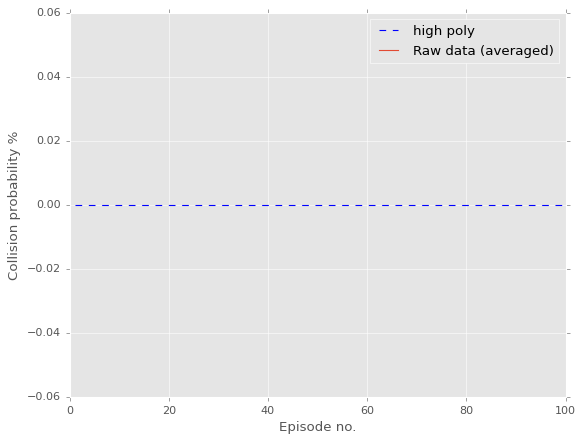

In [225]:

# Polynomial fit
t = np.linspace(1, ep_no, ep_no)
pfit_1 = np.polyfit(t, ch, 1)
pfit_2 = np.polyfit(t, ch, 2)
pfit_3 = np.polyfit(t, ch, 6)
linear_model = np.poly1d(pfit_1)
poly_model = np.poly1d(pfit_2)
high_poly_model = np.poly1d(pfit_3)


# Time / episode axis
# Moving average
window_width = 5000
cumsum_ch = np.cumsum(np.insert(ch, 0, 0)) 
ma_ch = (cumsum_ch[window_width:] - cumsum_ch[:-window_width]) / window_width
t2 = np.linspace(1, ep_no, len(ma_ch))

# Plotting
#plt.plot(t, ch, label="Raw data")
#plt.plot(t, linear_model(t), "m--", label="Linear")3
#plt.plot(t, poly_model(t), "r--", label="Poly")
plt.plot(t, high_poly_model(t), "b--", label="high poly")
#plt.legend()
#plt.show()
#
#plt.plot(t, ch, label="Raw data")
plt.plot(t2, ma_ch, label="Raw data (averaged)")
plt.legend(loc="upper right")


plt.ylabel("Collision probability %")
plt.xlabel("Episode no.")
plt.show()

## How about model error?


In [338]:
X = np.loadtxt('traindata/v40_v22_fw_dist_1_input.txt', dtype=float)
Y = np.loadtxt('traindata/v40_v22_fw_dist_1_output.txt', dtype=float)

In [339]:
X.shape, Y.shape

((118394, 6), (118394, 4))

In [340]:
print(X[600])

print(Y[600])

[-2.84007692  4.8390913   2.10500121  0.47525263  0.08304894  0.55714512]
[-2.32435727  4.2068696   1.38451052  0.54391903]


### Can this be learned?

In [345]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [346]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [356]:
# The model
model = tf.keras.Sequential()
# Input
model.add(layers.Dense(X.shape[-1], activation=tf.nn.relu))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(64, activation=tf.nn.relu))
# Output
model.add(layers.Dense(Y.shape[-1], activation="linear")) 
# Compile
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.MeanSquaredError(),
              metrics=['accuracy', 'mae']
              )

In [357]:
history = model.fit(x=X, y=Y,
                    batch_size=512, # Not setting gave 90% Accuracy
                    epochs=1000, verbose=0, validation_split = 0.2,
                    callbacks=[early_stop, PrintDot()])

c:\Users\henri\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)



....................................................................................................
....................................................................................................

In [358]:
hist1 = pd.DataFrame(history.history)
hist1['epoch'] = history.epoch
hist1.tail(1)

,loss,accuracy,mae,val_loss,val_accuracy,val_mae,epoch
199,0.528746,0.999715,0.310291,0.579297,1.0,0.365532,199


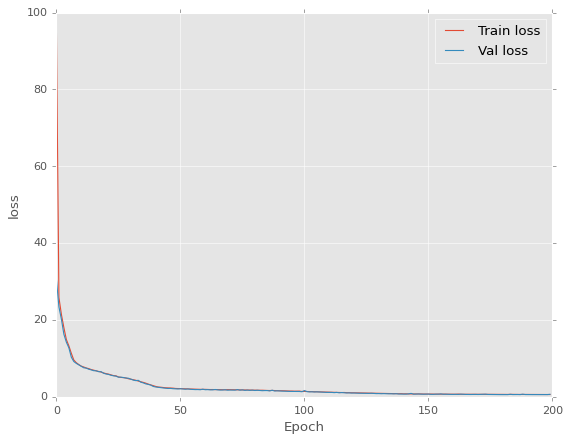

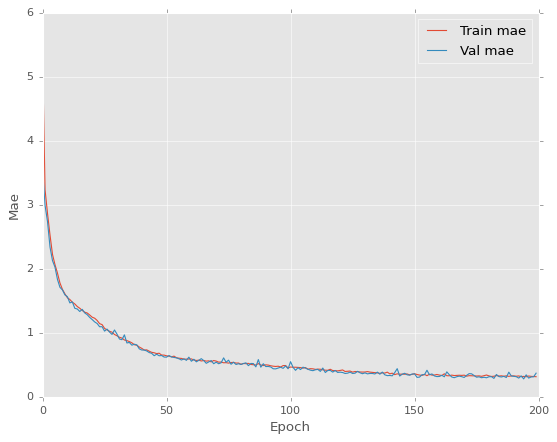

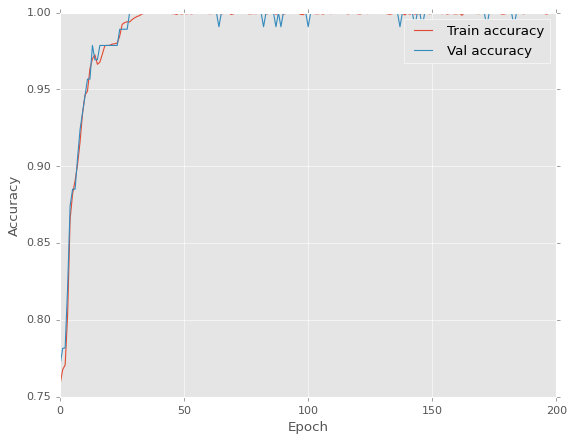

In [359]:
def plot_history_loss(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    #plt.yscale("log")
    plt.plot(hist['epoch'], hist['loss'], label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
    plt.plot()
    plt.legend()

def plot_history_mae(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mae')
    #plt.yscale("log")
    plt.plot(hist['epoch'], hist['mae'], label='Train mae')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val mae')
    plt.legend()

def plot_history_acc(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    #plt.yscale("log")
    plt.plot(hist['epoch'], hist['accuracy'], label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val accuracy')
    plt.legend()

plot_history_loss(hist1)
plot_history_mae(hist1)
plot_history_acc(hist1)

**Store model**

In [360]:

model.save('env_models/dist_model_1.h5')

In [361]:
model_loaded = keras.models.load_model('env_models/dist_model_1.h5')

c:\Users\henri\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


In [362]:
pred = model_loaded.predict(X[-1].reshape(1, 6))
print(pred)

1/1 [==============================] - 0s 73ms/step
[[-2.0016994   3.8858538   0.24978055  0.3347715 ]]


In [364]:
print(X[-1].reshape(1, 6))
print(pred)
print(Y[-1])

[[-2.32435727e+00  4.20686960e+00  1.38451052e+00  5.43919027e-01
   9.34740237e-04  3.35756660e-01]]
[[-2.0016994   3.8858538   0.24978055  0.3347715 ]]
[-2.15542388  3.91792107  0.2353628   0.36937603]


**How it should work**

- Once in a while, trains on a small batch of data, for a small amount of episodes.
- A small batch is extracted from the total data, and trained on